In [2]:
from holisticai.utils.trade_off_analysers import Fairea

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from holisticai.datasets import load_adult
from sklearn.model_selection import train_test_split

# Settings
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

# Dataset
data = load_adult()
df = pd.concat([data["data"], data["target"]], axis=1)

def preprocess_adult_dataset(df):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()

  # Get the protected attribute vectors
  group_a = df_clean["sex"] == "Female"
  group_b = df_clean["sex"] == "Male"

  group_a = np.squeeze(group_a.values)
  group_b = np.squeeze(group_b.values)
  # Remove unnecessary columns
  df_clean["class"].replace({">50K": 1, "<=50K": 0}, inplace=True)
  tmp = pd.get_dummies(df_clean.drop(columns=["sex", "race", "education", "class"]))
  df_clean = pd.concat([tmp, df_clean["class"].astype("uint8")], axis=1)
  return df_clean, group_a, group_b

df_clean, group_a, group_b = preprocess_adult_dataset(df)

X = df_clean.iloc[:,:-1].values
y = df_clean.iloc[:,-1].values

X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)

## Begin trade-off analysis with Fairea

In [4]:
fairea = Fairea(acc_metric='auc', fair_metric='sp', verbose=True)

### Create baseline and plot it

In [5]:
fairea.create_baseline(X_train, y_train, group_a_tr, group_b_tr)

Current datasplit: 0
Current datasplit: 1
Current datasplit: 2
Current datasplit: 3
Current datasplit: 4
Current datasplit: 5
Current datasplit: 6
Current datasplit: 7
Current datasplit: 8
Current datasplit: 9


<Axes: title={'center': 'Baseline Model'}, xlabel='Fairness', ylabel='Accuracy'>

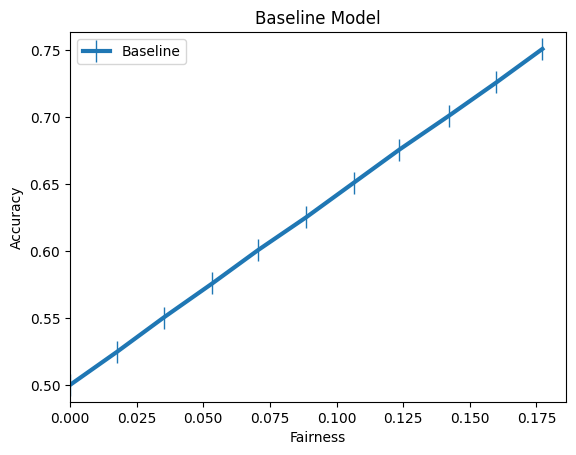

In [6]:
fairea.plot_baseline(title="Baseline Model", normalize=False)

### Add mitigation methods to the fairea object

In [11]:
# Preprocessing methods
from holisticai.bias.mitigation import CorrelationRemover

# Postprocessing methods
from holisticai.bias.mitigation import CalibratedEqualizedOdds

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [12]:
from holisticai.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", LogisticRegression()),
    ]
)

pipeline.fit(X_train, y_train, bm__group_a=group_a_tr, bm__group_b=group_b_tr)

y_pred = pipeline.predict(X_test, bm__group_a=group_a_ts, bm__group_b=group_b_ts)

In [13]:
fairea.add_mitigator("CorrelationRemover", y_test, y_pred, group_a_ts, group_b_ts)

In [14]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("estimator", LogisticRegression()),
        ("bm_postprocessing", CalibratedEqualizedOdds(cost_constraint="fnr")),
    ]
)

pipeline.fit(X_train, y_train, bm__group_a=group_a_tr, bm__group_b=group_b_tr)

y_pred = pipeline.predict(X_test, bm__group_a=group_a_ts, bm__group_b=group_b_ts)

In [16]:
fairea.add_mitigator("CalibratedEqualizedOdds", y_test, y_pred, group_a_ts, group_b_ts)

<Axes: title={'center': 'Baseline Model with Mitigators'}, xlabel='Fairness', ylabel='Accuracy'>

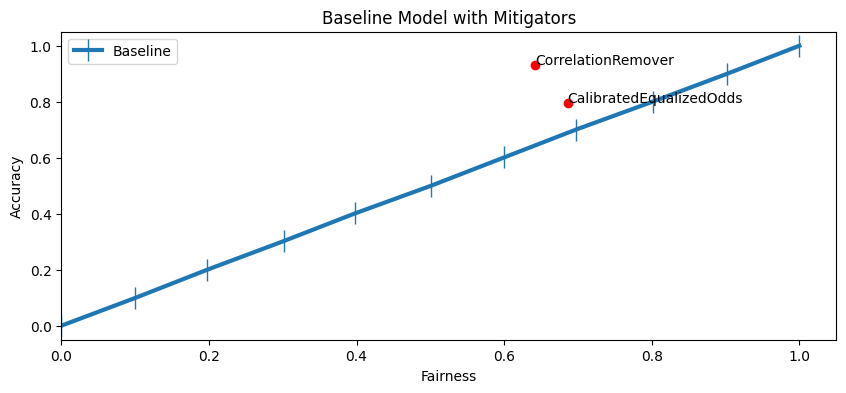

In [17]:
fairea.plot_methods(title="Baseline Model with Mitigators", normalize=True, size=(10, 4))

### Determine the region for the methods

In [18]:
fairea.region_classification()

,Region
CorrelationRemover,good trade-off
CalibratedEqualizedOdds,good trade-off


### Calculate area for "good trade-off" methods

In [19]:
fairea.determine_area()

,Area
CorrelationRemover,0.041977
CalibratedEqualizedOdds,0.005945


### Get best model

In [21]:
fairea.get_best()

'CorrelationRemover'